<a href="https://colab.research.google.com/github/frank-morales2020/Cloud_curious/blob/master/Copy_of_DAIGT_Mistral_7B_TPU_BFloat16_%5BTrain%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data?select=train_essays.csv

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alejopaullier/daigt-external-dataset")

print("Path to dataset files:", path)

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

datafan07_mistral_7b_v0_1_path = kagglehub.dataset_download('datafan07/mistral-7b-v0-1')
print("Path to dataset files:", datafan07_mistral_7b_v0_1_path )
# /root/.cache/kagglehub/datasets/datafan07/mistral-7b-v0-1/versions/1/Mistral-7B-v0.1

defdet_utils_xla_path = kagglehub.dataset_download('defdet/utils-xla')
print("Path to dataset files:", defdet_utils_xla_path )

alejopaullier_daigt_external_dataset_path = kagglehub.dataset_download('alejopaullier/daigt-external-dataset')
print("Path to dataset files:", alejopaullier_daigt_external_dataset_path )

thedrcat_daigt_proper_train_dataset_path = kagglehub.dataset_download('thedrcat/daigt-proper-train-dataset')
print("Path to dataset files:", thedrcat_daigt_proper_train_dataset_path )

print('Data source import complete.')


In [7]:
!mkdir -p /content/gdrive/MyDrive/TPU
!cp -pr /root/.cache/kagglehub/datasets/datafan07/mistral-7b-v0-1/versions/1/Mistral-7B-v0.1 /content/gdrive/MyDrive/TPU/Mistral-7B-v0.1


In [ ]:
!pip install colab-env -q
import colab_env

In [ ]:
#!cp -pr /kaggle/input /content/gdrive/MyDrive/TPU/
!ls -ltha /content/gdrive/MyDrive/TPU/input/
!cp -pr /content/gdrive/MyDrive/TPU/input/utils-xla/spmd_util.py /content/
!ls -ltha /content/

In [ ]:
!pip install -qq peft==0.6.0
!pip install -qq bitsandbytes==0.41.1
!pip install -qq accelerate==0.24.1
!pip install -qq transformers==4.35.0
!pip install -qq sentencepiece==0.1.99
!pip install -qq nltk==3.8.1
!pip install -qq torch~=2.1.0 --index-url https://download.pytorch.org/whl/cpu -q # Updating torch since we need the latest version
!pip install -qq torch_xla[tpu]~=2.1.0 -f https://storage.googleapis.com/libtpu-releases/index.html -q
!pip uninstall -qq tensorflow -y # If we don't do this, TF will take over TPU and cause permission error for PT

In [ ]:
import torch
import transformers
import sklearn
import os
import gc
import re
import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, LlamaModel, LlamaForSequenceClassification
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from transformers import BitsAndBytesConfig

import torch_xla.debug.profiler as xp
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp # We also import mp modules if we wanna use that for some reason
import torch_xla.distributed.parallel_loader as pl
import torch_xla.test.test_utils as test_utils

import torch_xla.experimental.xla_sharding as xs
import torch_xla.core.xla_model as xm
from transformers import (
    GPTNeoXConfig, T5Config, LlamaConfig, AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding, AutoConfig, AutoModelForSequenceClassification
) # You can use any of models with those configs (even flan T5 xxl!). Other models are not supported.

import torch_xla.runtime as xr

xr.use_spmd()

import torch_xla.experimental.xla_sharding as xs # "experimental" prefix always means you're gonna have a good time LMAO
from torch_xla.experimental.xla_sharded_tensor import XLAShardedTensor
from torch_xla.experimental.xla_sharding import Mesh
%cd /content/
from spmd_util import partition_module

tqdm.pandas()

nltk.download('punkt')

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 99

print(f'Torch Version: {torch.__version__}')

# Config

In [2]:
# Initialize TPU Device
DEVICE = xm.xla_device()
# Number Of Training Epochs
NUM_EPOCHS = 1
# Batch Size, should be evenly divisable by 8, since there are 8 TPU Nodes
BATCH_SIZE = 16
# Context Length of text in tokens, not words
MAX_LENGTH = 1024
# Number of Warmup Steps
NUM_WARMUP_STEPS = 128
# Maximum Learning RAte
LR_MAX = 5e-5
# Number of Labels, 1 sigmoid neuron with: 0=human, 1=AI
NUM_LABELS = 1
# We use the already famous Mistral-7B Model!
TARGET_MODEL = 'mistralai/Mistral-7B-v0.1'

# Tokenizer

In [ ]:
from transformers import AutoTokenizer
# Huggingface Tokenizer

#tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-v0.1')
tokenizer = AutoTokenizer.from_pretrained('/content/gdrive/MyDrive/TPU/Mistral-7B-v0.1')
# Set PAD token
tokenizer.pad_token = tokenizer.eos_token
# save tokenizer to load offline during inference
tokenizer.save_pretrained('tokenizer')

In [4]:
# Utility function giving token length
def get_token_lengths(texts):
    # tokenize and reaceive input_ids for reach text
    input_ids = tokenizer(texts.tolist(), return_tensors='np')['input_ids']
    # return length of inputs_ids for each text
    return [len(t) for t in input_ids]

# Train Data

In [5]:
import pandas as pd
# Competition training data which we will not use
train_essays = pd.read_csv('/content/gdrive/MyDrive/TPU/input/train_essays.csv')

# Add Text Length
train_essays['token_count'] = get_token_lengths(train_essays['text'])

# Display data
display(train_essays.head())
display(train_essays.info())

,id,prompt_id,text,generated,token_count
0,0059830c,0,"Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and ...",0,750
1,005db917,0,"Transportation is a large necessity in most countries worldwide. With no doubt, cars, buses, an...",0,618
2,008f63e3,0,"""America's love affair with it's vehicles seems to be cooling"" says Elisabeth rosenthal. To und...",0,936
3,00940276,0,How often do you ride in a car? Do you drive a one or any other motor vehicle to work? The stor...,0,892
4,00c39458,0,Cars are a wonderful thing. They are perhaps one of the worlds greatest advancements and techno...,0,1121


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1378 non-null   object
 1   prompt_id    1378 non-null   int64 
 2   text         1378 non-null   object
 3   generated    1378 non-null   int64 
 4   token_count  1378 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 54.0+ KB


None

In [6]:
display(train_essays['generated'].value_counts().to_frame())

,count
generated,
0,1375
1,3


,token_count
count,1378
mean,713
std,215
min,278
25%,570
50%,671
75%,813
max,2420


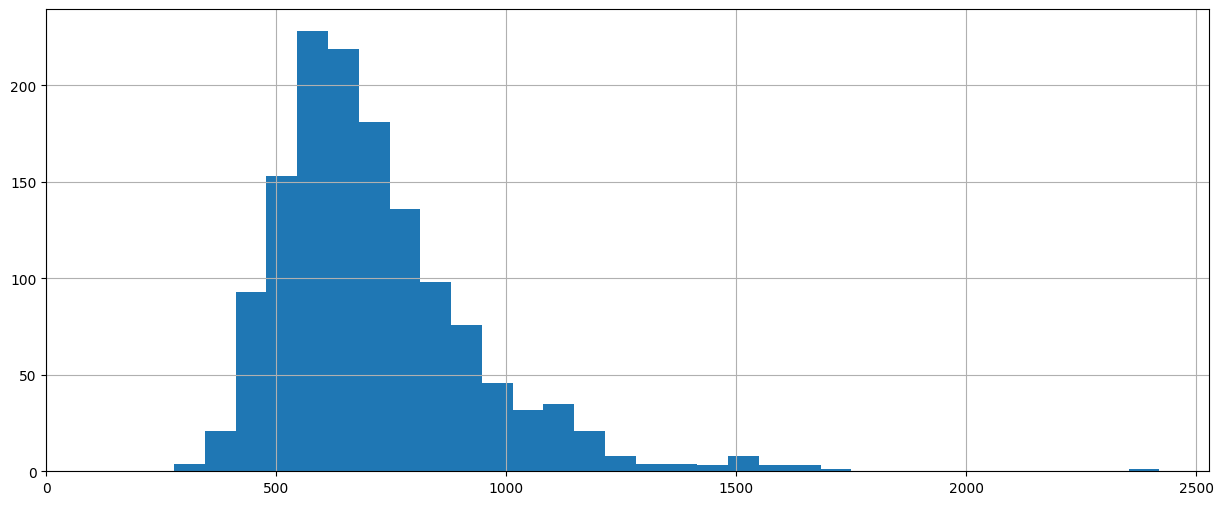

In [7]:
# Token Count
display(train_essays['token_count'].describe().to_frame().astype(int))
plt.figure(figsize=(15,6))
plt.hist(train_essays['token_count'], bins=32)
plt.xlim(0, plt.xlim()[1])
plt.grid()
plt.show()

# Proper Train Dataset

In [8]:
# Use the widely used "proper_train_dataset"
proper_train_dataset = pd.read_csv('/content/gdrive/MyDrive/TPU/input/daigt-proper-train-dataset/train_drcat_04.csv')

# Add Text Length
proper_train_dataset['token_count'] = get_token_lengths(proper_train_dataset['text'])

display(proper_train_dataset.head())
display(proper_train_dataset.info())

,essay_id,text,label,source,prompt,fold,token_count
0,E897534557AF,"In recent years, technology has had a profound impact on our daily lives and the world around ...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive impact of technology and how it makes humans bei...,1,315
1,DFBA34FFE11D,"Should students participate in an extracurricular activity? It may seem like a simple question,...",0,persuade_corpus,NaN,2,791
2,af37ecf5,The electoral college is a symbol of mockery and deprivation of our rights. Voting using this s...,0,train_essays,NaN,5,703
3,5EC2696BAD78,This is why I think the principle should allow students to bring phones to school and use them ...,0,persuade_corpus,NaN,8,232
4,llama_70b_v1843,I strongly believe that meditation and mindfulness practices should be included in schools. The...,1,llama_70b_v1,Some schools have implemented meditation and mindfulness practices into the school day. Write a...,0,424


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   essay_id     44206 non-null  object
 1   text         44206 non-null  object
 2   label        44206 non-null  int64 
 3   source       44206 non-null  object
 4   prompt       12911 non-null  object
 5   fold         44206 non-null  int64 
 6   token_count  44206 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.4+ MB


None

,token_count
count,44206
mean,484
std,220
min,65
25%,341
50%,449
75%,573
max,9293


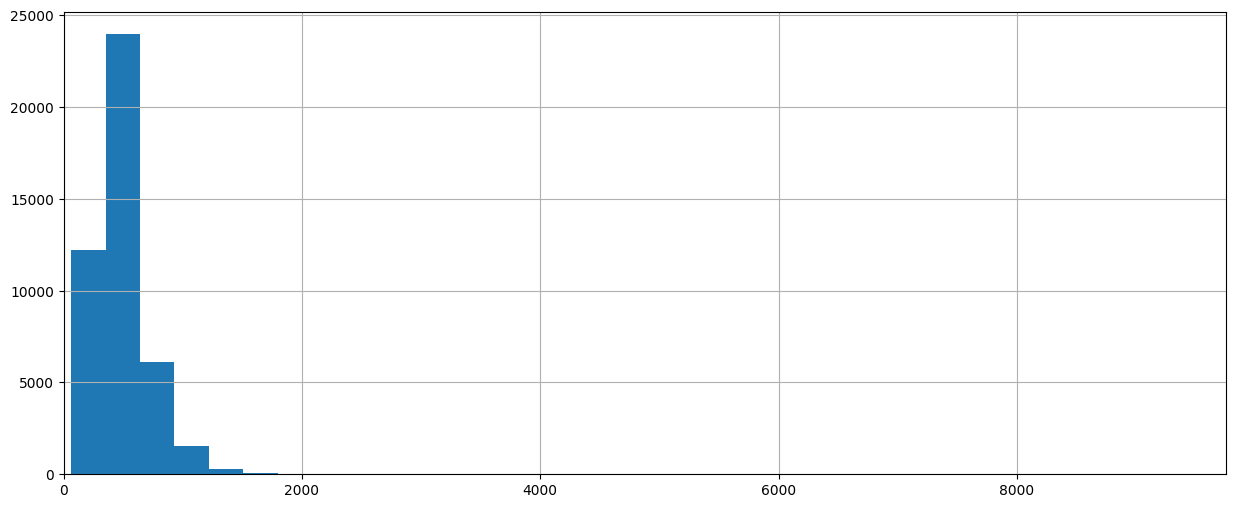

In [9]:
# Word Count
display(proper_train_dataset['token_count'].describe().to_frame().astype(int))
plt.figure(figsize=(15,6))
plt.hist(proper_train_dataset['token_count'], bins=32)
plt.xlim(0, plt.xlim()[1])
plt.grid()
plt.show()

# Sample Submission

In [10]:
sample_submission = pd.read_csv('/content/gdrive/MyDrive/TPU/input/sample_submission.csv')

display(sample_submission)

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


# Prepare Train Data

In [11]:
# Label Columns
LABEL = 'label'
# Columns to Use
columns = ['text', LABEL]
# Acquire Training DataFrame
df = proper_train_dataset[columns]

display(df.info())
# Label Counts
display(df[LABEL].value_counts().to_frame())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44206 non-null  object
 1   label   44206 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 690.8+ KB


None

,count
label,
0,29792
1,14414


In [12]:
N_SAMPLES = len(df)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 44206


# Tokenize Inputs

In [13]:
# Tokenize Data
tokens = tokenizer(
    df['text'].tolist(), # Texts
    padding='max_length', # Pad texts to maximum length
    max_length=MAX_LENGTH, # Maximum token length
    truncation=True, # Truncate texts if they are too long
    return_tensors='np', # Return Numpy array
)

# Input IDs are the token IDs
INPUT_IDS = tokens['input_ids']
# Attention Masks to Ignore Padding Tokens
ATTENTION_MASKS = tokens['attention_mask']
# Generated By AI Label of Texts
GENERATED = df[LABEL].values.reshape(-1,1).astype(np.float32)

print(f'INPUT_IDS shape: {INPUT_IDS.shape}, ATTENTION_MASKS shape: {ATTENTION_MASKS.shape}')
print(f'GENERATED shape: {GENERATED.shape}')

INPUT_IDS shape: (44206, 1024), ATTENTION_MASKS shape: (44206, 1024)
GENERATED shape: (44206, 1)


# Model

In [ ]:
# Load BigBird model for classification with 1 target label
base_model = LlamaForSequenceClassification.from_pretrained(
    '/content/gdrive/MyDrive/TPU/Mistral-7B-v0.1',
    num_labels=NUM_LABELS,
    torch_dtype=torch.bfloat16,
)
# No idea why this is needed
base_model.config.pretraining_tp = 1 # 1 is 7b
# Assign Padding TOKEN
base_model.config.pad_token_id = tokenizer.pad_token_id

# Low-Rank Adaptation

Based on this paper: [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)

In [15]:
# LoRa
peft_config = LoraConfig(
    r=16,
    lora_dropout=0.10,
    bias='none',
    inference_mode=False,
    task_type=TaskType.SEQ_CLS,
    # Only Use Output and Values Projection
    target_modules=[
        'o_proj',
        'v_proj',
    ],
)

In [16]:
# Create LoRa Model
model = get_peft_model(base_model, peft_config)

In [17]:
# Trainable Parameters
model.print_trainable_parameters()

trainable params: 6,819,840 || all params: 7,117,484,032 || trainable%: 0.09581812855972979


In [18]:
# Verfy The Trainable Layers
MODEL_LAYERS_ROWS = []
TRAINABLE_PARAMS = []
N_TRAINABLE_PARAMS = 0

for name, param in model.named_parameters():
    # Layer Parameter Count
    n_parameters = int(torch.prod(torch.tensor(param.shape)))
    # Only Trainable Layers
    if param.requires_grad:
        # Add Layer Information
        MODEL_LAYERS_ROWS.append({
            '#param': n_parameters,
            'name': name,
            'dtype': param.data.dtype,
        })
        # Append Trainable Parameter
        TRAINABLE_PARAMS.append({ 'params': param })
        # Add Number Of Trainable Parameters"
        N_TRAINABLE_PARAMS += n_parameters

display(pd.DataFrame(MODEL_LAYERS_ROWS))

print(f"""
===============================
N_TRAINABLE_PARAMS: {N_TRAINABLE_PARAMS:,}
N_TRAINABLE_LAYERS: {len(TRAINABLE_PARAMS)}
===============================
""")

,#param,name,dtype
0,65536,base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight,torch.float32
1,16384,base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight,torch.float32
2,65536,base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight,torch.float32
3,65536,base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight,torch.float32
4,65536,base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight,torch.float32
5,16384,base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight,torch.float32
6,65536,base_model.model.model.layers.1.self_attn.o_proj.lora_A.default.weight,torch.float32
7,65536,base_model.model.model.layers.1.self_attn.o_proj.lora_B.default.weight,torch.float32
8,65536,base_model.model.model.layers.2.self_attn.v_proj.lora_A.default.weight,torch.float32
9,16384,base_model.model.model.layers.2.self_attn.v_proj.lora_B.default.weight,torch.float32



N_TRAINABLE_PARAMS: 6,819,840
N_TRAINABLE_LAYERS: 129



In [19]:
# Number of TPU Nodes
num_devices = xr.global_runtime_device_count()
mesh_shape = (1, num_devices, 1)
device_ids = np.array(range(num_devices))
mesh = Mesh(device_ids, mesh_shape, ('dp', 'fsdp', 'mp'))
partition_module(model, mesh)

print(f'num_devices: {num_devices}')

num_devices: 1


# Learning Rate & Optimizer

In [20]:
STEPS_PER_EPOCH = N_SAMPLES // BATCH_SIZE

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LR_MAX)
# Cosine Learning Rate With Warmup
lr_scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer=OPTIMIZER,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=STEPS_PER_EPOCH * NUM_EPOCHS,
)


print(f'BATCH_SIZE: {BATCH_SIZE}, N_SAMPLES: {N_SAMPLES}, STEPS_PER_EPOCH: {STEPS_PER_EPOCH}')

BATCH_SIZE: 16, N_SAMPLES: 44206, STEPS_PER_EPOCH: 2762


In [21]:
# Set the data type for the optimizer's state (e.g., momentum buffers)
for state in OPTIMIZER.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor) and state[k].dtype is not torch.float32:
            state[v] = v.to(dtype=torch.float32)

# Dataset

In [22]:
POS_IDXS = np.argwhere(df[LABEL] == 1).squeeze()
NEG_IDXS = np.argwhere(df[LABEL] == 0).squeeze()

print(f'#POS_IDXS: {POS_IDXS.size}, #NEG_IDXS: {NEG_IDXS.size}')

#POS_IDXS: 14414, #NEG_IDXS: 29792


In [23]:
def train_dataset(batch_size):
    IDXS = np.arange(N_SAMPLES-(N_SAMPLES%batch_size))
    while True:
        # Shuffle Indices
        np.random.shuffle(IDXS)
        # Iterate Over All Indices Once
        for idxs in IDXS.reshape(-1,batch_size):
            input_ids = torch.tensor(INPUT_IDS[idxs], dtype=torch.int64).to(DEVICE)
            attention_mask = torch.tensor(ATTENTION_MASKS[idxs], dtype=torch.int64).to(DEVICE)
            labels = torch.tensor(GENERATED[idxs], dtype=torch.float32).to(DEVICE)
            # Shard Over TPU Nodes
            xs.mark_sharding(input_ids, mesh, (0, 1))
            xs.mark_sharding(attention_mask, mesh, (0, 1))
            xs.mark_sharding(labels, mesh, (0, 1))

            yield input_ids, attention_mask, labels

TRAIN_DATASET = train_dataset(BATCH_SIZE)

In [24]:
input_ids, attention_mask, labels = next(TRAIN_DATASET)

print(f'input_ids shape: {input_ids.shape}, dtype: {input_ids.dtype}')
print(f'attention_mask shape: {attention_mask.shape}, dtype: {attention_mask.dtype}')
print(f'labels shape: {labels.shape}, dtype: {labels.dtype}')

input_ids shape: torch.Size([16, 1024]), dtype: torch.int64
attention_mask shape: torch.Size([16, 1024]), dtype: torch.int64
labels shape: torch.Size([16, 1]), dtype: torch.float32


In [25]:
#import torch

# Dummy Prediction
#with torch.no_grad():
    #outputs = model(input_ids=input_ids, attention_mask=attention_mask)

#print(f'logits: {outputs.logits}, dtype: {outputs.logits.dtype}')
# print(f'loss: {outputs.loss}, dtype: {outputs.loss.dtype}')

# Training

In [26]:
# Put Model In Train Modus
model.train()

# Loss Function, basic Binary Cross Entropy
LOSS_FN = torch.nn.BCEWithLogitsLoss().to(dtype=torch.float32)

In [ ]:
for epoch in tqdm(range(NUM_EPOCHS)):
    METRICS = {
        'loss': [],
        'auc': {
            'y_true': [],
            'y_pred': [],
        },
    }

    for step in range(STEPS_PER_EPOCH):
        # Zero Out Gradients
        OPTIMIZER.zero_grad()
        # Get Batch
        input_ids, attention_mask, labels = next(TRAIN_DATASET)
        # Forward Pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Logits Float32
        logits = outputs.logits.to(dtype=torch.float32)
        # Backward Pass
        loss = LOSS_FN(logits, labels)
        loss.backward()
        # Update Weights
        OPTIMIZER.step()
        xm.mark_step()
        # Update Learning Rate Scheduler
        lr_scheduler.step()
        # Update Metrics And Progress Bar
        METRICS['loss'].append(float(loss))
        METRICS['auc']['y_true'] += labels.squeeze().tolist()
        METRICS['auc']['y_pred'] += logits.sigmoid().tolist()
        # Metrics Shown After Both Classes Present
        if np.unique(METRICS['auc']['y_true']).size == 2:
            metrics = 'µ_loss: {:.3f}'.format(np.mean(METRICS['loss']))
            metrics += ', step_loss: {:.3f}'.format(METRICS['loss'][-1])
            metrics += ', µ_auc: {:.3f}'.format(
                sklearn.metrics.roc_auc_score(METRICS['auc']['y_true'], METRICS['auc']['y_pred'])
            )

            lr = OPTIMIZER.param_groups[0]['lr']
            print('\r'*100, f'{epoch+1:02}/{NUM_EPOCHS:02} | {step+1:04}/{STEPS_PER_EPOCH} lr: {lr:.2E}, {metrics}', end='')

  0%|          | 0/1 [00:00<?, ?it/s]

# Save Model

In [ ]:
# Important step, put model first on CPU before saving weights
#model = model.cpu()

In [ ]:
# Only saving the newly trained weights
#torch.save(dict([(k,v) for k, v in model.named_parameters() if v.requires_grad]), 'model')